Dataset link: https://www.kaggle.com/datasets/harshalhonde/starbucks-reviews-dataset/data

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

### Importing CSV file

In [57]:
df = pd.read_csv('reviews_data.csv')
df.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [58]:
df.shape

(850, 6)

In [31]:
import warnings

warnings.filterwarnings('ignore')

### Selecting 'Rating' and 'Review' Column

In [59]:
df.drop(['name','location','Date','Image_Links'], axis=1, inplace=True)

### Dropping duplicate values

In [60]:
df.drop_duplicates(inplace=True)

### Dropping NaN values

In [61]:
df.dropna(inplace=True)

In [62]:
df.shape

(705, 2)

In [63]:
df.head()

,Rating,Review
0,5.0,Amber and LaDonna at the Starbucks on Southwes...
1,5.0,** at the Starbucks by the fire station on 436...
2,5.0,I just wanted to go out of my way to recognize...
3,5.0,Me and my friend were at Starbucks and my card...
4,5.0,I’m on this kick of drinking 5 cups of warm wa...


In [64]:
df['Rating'].unique()

array([5., 1., 2., 3., 4.])

In [65]:
df['Rating'].dtype

dtype('float64')

In [66]:
df['Rating'] = df['Rating'].astype(int)

In [67]:
df['Rating'].unique()

array([5, 1, 2, 3, 4])

### Text Preprocessing

In [68]:
df['Review'].replace("[^a-zA-Z]"," ",regex=True, inplace=True)

In [69]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

In [70]:
for i in range(df.shape[0]):
    # Lowering the review
    review = df.iloc[i,1].lower()
    # Spliting all the words
    review = review.split()
    # Removing Stop Words
    review = [word for word in review if word not in set(stopwords.words('english'))]
    # Lemmatization
    review = [lemma.lemmatize(word) for word in review]
    # Joining all remaining words
    review = " ".join(review)
    df.iloc[i,1] = review

In [54]:
df.head()

,Rating,Review
0,5,amber ladonna starbucks southwest parkway alwa...
1,5,starbucks fire station altamonte springs fl ma...
2,5,wanted go way recognize starbucks employee bil...
3,5,friend starbucks card work thankful worker pai...
4,5,kick drinking cups warm water work instacart r...


In [78]:
df['Rating'].value_counts()

Rating
1    451
2     99
5     83
4     39
3     33
Name: count, dtype: int64

### Balance our data set using down sampling

In [79]:
rt1 = df[df['Rating'] == 1]
rt2 = df[df['Rating'] == 2]
rt3 = df[df['Rating'] == 3]
rt4 = df[df['Rating'] == 4]
rt5 = df[df['Rating'] == 5]

In [84]:
balanced_df = pd.concat([rt1.sample(39),rt2.sample(39),rt3,rt4,rt5.sample(39)],axis=0)

In [85]:
balanced_df.head()

,Rating,Review
484,1,generally receive great service starbucks nata...
497,1,ordered blueberry oatmeal blueberry come separ...
581,1,poor service paying customer non paying custom...
621,1,balance showing card every time looked quite t...
503,1,frequently go different coffee shop want latte...


### Convert Words into Vectors

In [71]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [86]:
bow = CountVectorizer(ngram_range=(1,2))
X = bow.fit_transform(balanced_df['Review'])

### Independent Variable

In [87]:
X.shape

(189, 8386)

### Dependent Variable

In [88]:
y = balanced_df['Rating']

In [89]:
y.value_counts()

Rating
1    39
2    39
4    39
5    39
3    33
Name: count, dtype: int64

### Splitting training and testing set

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [91]:
y_train.value_counts()

Rating
2    31
1    31
4    31
5    31
3    27
Name: count, dtype: int64

### Logistic Regression

### Training the model

In [92]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train,y_train)

LogisticRegression()

### Accuracy Score

In [93]:
clf.score(X_test,y_test)

0.42105263157894735

### Prediction

In [94]:
y_pred = clf.predict(X_test)

In [95]:
y_pred

array([1, 1, 3, 2, 3, 5, 2, 2, 2, 5, 4, 4, 2, 4, 2, 4, 1, 1, 2, 2, 2, 2,
       4, 2, 4, 2, 2, 4, 2, 5, 4, 4, 5, 5, 4, 4, 4, 4])

### Confusion Matrix

In [96]:
from sklearn.metrics import confusion_matrix, classification_report

In [97]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[2, 3, 2, 1, 0],
       [2, 6, 0, 0, 0],
       [0, 2, 0, 4, 0],
       [0, 3, 0, 4, 1],
       [0, 0, 0, 4, 4]], dtype=int64)

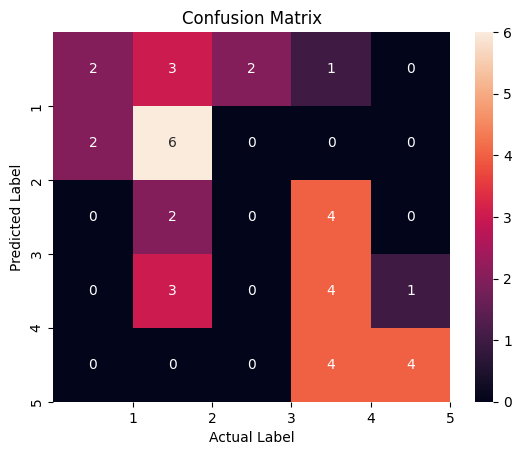

In [104]:
sns.heatmap(cm,annot=True)
plt.title("Confusion Matrix")
plt.xticks([1,2,3,4,5],labels=[1,2,3,4,5])
plt.yticks([1,2,3,4,5],labels=[1,2,3,4,5])
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.show()

### Classification Report

In [100]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.50      0.25      0.33         8
           2       0.43      0.75      0.55         8
           3       0.00      0.00      0.00         6
           4       0.31      0.50      0.38         8
           5       0.80      0.50      0.62         8

    accuracy                           0.42        38
   macro avg       0.41      0.40      0.38        38
weighted avg       0.43      0.42      0.39        38

